In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [41]:
BATCH_SIZE = 100

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [43]:
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [44]:
class OverFit_model(nn.Module):
    def __init__(self):
        super(OverFit_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.fc1 = nn.Linear(512, 1024) 
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        self.pool = nn.MaxPool2d(2, 2)
        
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [48]:
# OverFit_model

learning_rate = 0.001
num_epochs = 50

losses_OverFit_model_train = list()
accuracies_OverFit_model_train = list()

losses_OverFit_model_test = list()
accuracies_OverFit_model_test = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = OverFit_model()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    

    ## test step
    model = model.eval()
    with torch.no_grad():
      test_running_loss = 0.0
      test_acc = 0.0

      for i, (images, labels) in enumerate(testloader):
                
          images = images.to(device)
          labels = labels.to(device)

          logits = model(images)
          loss = criterion(logits, labels)

          test_running_loss += loss.detach().item()
          test_acc += get_accuracy(logits, labels, BATCH_SIZE)
        
        
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / len(trainloader), train_acc/len(trainloader)))
    print('   Test   | Loss : %.4f | Test Accuracy: %.2f'\
          %(test_running_loss / len(testloader), test_acc/len(testloader)))
    
    losses_OverFit_model_train.append(train_running_loss/len(trainloader))
    accuracies_OverFit_model_train.append(train_acc/len(trainloader))
    losses_OverFit_model_test.append(test_running_loss/len(testloader))
    accuracies_OverFit_model_test.append(test_acc/len(testloader))


Epoch: 0 | Loss: 2.3006 | Train Accuracy: 10.70
   Test   | Loss : 2.2970 | Test Accuracy: 15.18
Epoch: 1 | Loss: 2.2856 | Train Accuracy: 18.15
   Test   | Loss : 2.2524 | Test Accuracy: 19.34
Epoch: 2 | Loss: 2.1298 | Train Accuracy: 21.43
   Test   | Loss : 1.9963 | Test Accuracy: 26.97
Epoch: 3 | Loss: 1.9383 | Train Accuracy: 28.12
   Test   | Loss : 1.8305 | Test Accuracy: 32.75
Epoch: 4 | Loss: 1.7929 | Train Accuracy: 32.81
   Test   | Loss : 1.6831 | Test Accuracy: 37.34
Epoch: 5 | Loss: 1.7000 | Train Accuracy: 35.99
   Test   | Loss : 1.5836 | Test Accuracy: 40.42
Epoch: 6 | Loss: 1.6271 | Train Accuracy: 39.42
   Test   | Loss : 1.5260 | Test Accuracy: 43.14
Epoch: 7 | Loss: 1.5547 | Train Accuracy: 42.22
   Test   | Loss : 1.4217 | Test Accuracy: 47.96
Epoch: 8 | Loss: 1.4840 | Train Accuracy: 45.05
   Test   | Loss : 1.3747 | Test Accuracy: 49.24
Epoch: 9 | Loss: 1.4351 | Train Accuracy: 47.53
   Test   | Loss : 1.3206 | Test Accuracy: 52.16
Epoch: 10 | Loss: 1.3786 | Tra

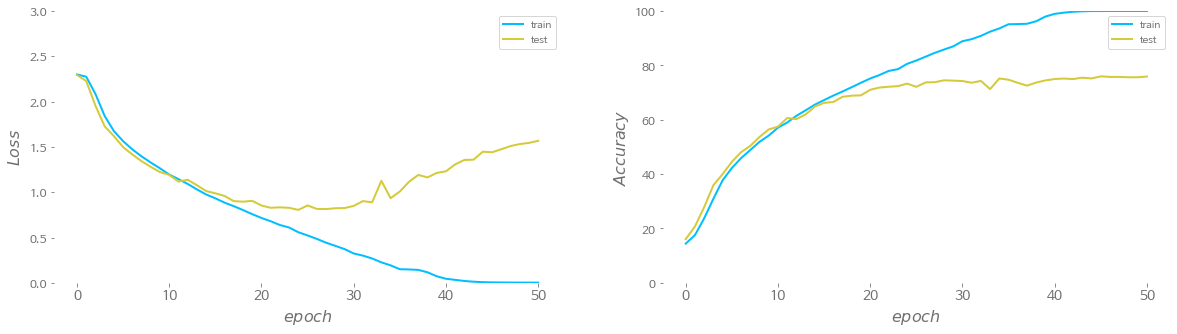

In [17]:
# Plot result

# OverFit_model_train : losses_OverFit_model_train / accuracies_OverFit_model_train
# OverFit_model_test : losses_OverFit_model_test / accuracies_OverFit_model_test


import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.plot(losses_OverFit_model_train, label = 'train')
plt.plot(losses_OverFit_model_test, label = 'test')
plt.legend()
plt.grid()
plt.xlabel("$epoch$", fontsize=16)
plt.ylabel("$Loss$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.ylim([0, 3])

plt.subplot(1, 2, 2)
plt.plot(accuracies_OverFit_model_train, label = 'train')
plt.plot(accuracies_OverFit_model_test, label = 'test')

plt.grid()
plt.xlabel("$epoch$", fontsize=16)
plt.ylabel("$Accuracy$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(np.arange(0, 100))
plt.ylim([0, 100])



plt.legend()
plt.show()

In [45]:
class Solution_model(nn.Module):
    def __init__(self):
        super(Solution_model, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 64, 3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        
    
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(F.relu(self.bn1(x))))
        x = self.pool(self.conv3(F.relu(self.bn2(x))))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [46]:
# Solution_model

learning_rate = 0.001
num_epochs = 50

losses_Solution_model_train = list()
accuracies_Solution_model_train = list()

losses_Solution_model_test = list()
accuracies_Solution_model_test = list()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Solution_model()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    

    ## test step
    model = model.eval()
    with torch.no_grad():
      test_running_loss = 0.0
      test_acc = 0.0

      for i, (images, labels) in enumerate(testloader):
                
          images = images.to(device)
          labels = labels.to(device)

          logits = model(images)
          loss = criterion(logits, labels)

          test_running_loss += loss.detach().item()
          test_acc += get_accuracy(logits, labels, BATCH_SIZE)
        
        
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / len(trainloader), train_acc/len(trainloader)))
    print('   Test   | Loss : %.4f | Test Accuracy: %.2f'\
          %(test_running_loss / len(testloader), test_acc/len(testloader)))
    
    losses_Solution_model_train.append(train_running_loss/len(trainloader))
    accuracies_Solution_model_train.append(train_acc/len(trainloader))
    losses_Solution_model_test.append(test_running_loss/len(testloader))
    accuracies_Solution_model_test.append(test_acc/len(testloader))


Epoch: 0 | Loss: 2.0769 | Train Accuracy: 23.40
   Test   | Loss : 1.8541 | Test Accuracy: 31.49
Epoch: 1 | Loss: 1.7819 | Train Accuracy: 33.35
   Test   | Loss : 1.6357 | Test Accuracy: 39.39
Epoch: 2 | Loss: 1.6320 | Train Accuracy: 39.32
   Test   | Loss : 1.5209 | Test Accuracy: 44.51
Epoch: 3 | Loss: 1.5354 | Train Accuracy: 44.15
   Test   | Loss : 1.4152 | Test Accuracy: 48.93
Epoch: 4 | Loss: 1.4567 | Train Accuracy: 47.16
   Test   | Loss : 1.3563 | Test Accuracy: 51.06
Epoch: 5 | Loss: 1.4144 | Train Accuracy: 48.76
   Test   | Loss : 1.3105 | Test Accuracy: 52.66
Epoch: 6 | Loss: 1.3722 | Train Accuracy: 50.41
   Test   | Loss : 1.2590 | Test Accuracy: 54.81
Epoch: 7 | Loss: 1.3408 | Train Accuracy: 51.89
   Test   | Loss : 1.2315 | Test Accuracy: 55.85
Epoch: 8 | Loss: 1.3159 | Train Accuracy: 52.95
   Test   | Loss : 1.2093 | Test Accuracy: 56.97
Epoch: 9 | Loss: 1.3002 | Train Accuracy: 53.38
   Test   | Loss : 1.1877 | Test Accuracy: 57.70
Epoch: 10 | Loss: 1.2755 | Tra

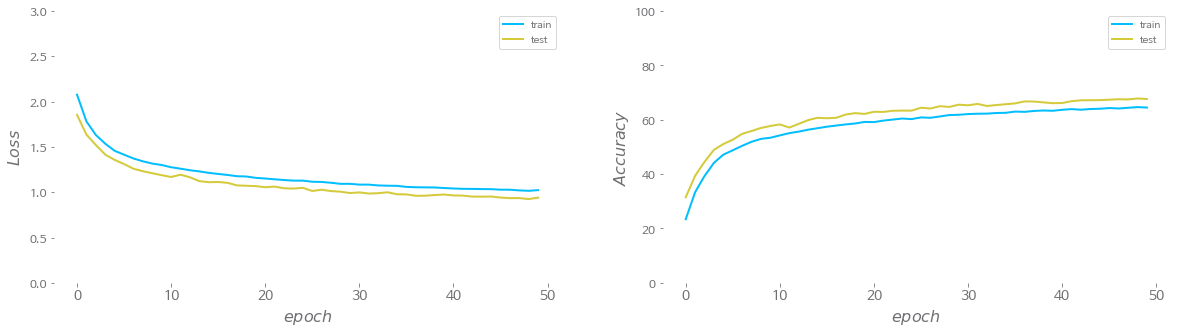

In [47]:
# Plot result

# OverFit_model_train : losses_OverFit_model_train / accuracies_OverFit_model_train
# OverFit_model_test : losses_OverFit_model_test / accuracies_OverFit_model_test
# Solution_model_train : losses_Solution_model_train / accuracies_Solution_model_train
# Solution_model_test : losses_Solution_model_test / accuracies_Solution_model_test



import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.plot(losses_Solution_model_train, label = 'train')
plt.plot(losses_Solution_model_test, label = 'test')
plt.legend()
plt.grid()
plt.xlabel("$epoch$", fontsize=16)
plt.ylabel("$Loss$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
plt.ylim([0, 3])

plt.subplot(1, 2, 2)
plt.plot(accuracies_Solution_model_train, label = 'train')
plt.plot(accuracies_Solution_model_test, label = 'test')

plt.grid()
plt.xlabel("$epoch$", fontsize=16)
plt.ylabel("$Accuracy$", fontsize=16)
plt.xticks(fontsize=14)
# plt.yticks(np.arange(0, 100))
plt.ylim([0, 100])



plt.legend()
plt.show()